In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import pandas
import seaborn
import gzip
from Bio import SeqIO
import pyprind

Populating the interactive namespace from numpy and matplotlib


In [2]:
# dataset properties

fraglength = 3000  # fastANI fragment length 
kmer       = 16    # fastANI k-mer length
min_aln    = 10    # minimum number of aligned fragments
max_ani    = 99.95 # maximum ANI threshold

In [3]:
imgvr_dtypes = {
    'UViG' : str,
    'Taxon_oid' : str,
    'Scaffold_oid' : str,
    'Coordinates (\'whole\' if the UViG is the entire contig)' : str,
    'Ecosystem classification' : str,
    'vOTU' : str,
    'Length' : int,
    'Topology' : str,
    'Estimated completeness' : float,
    'MIUViG quality' : str,
    'Gene content (total genes;cds;tRNA;VPF percentage)' : str,
    'Taxonomic classification' : str,
    'Taxonomic classification method' : str,
    'Host taxonomy prediction' : str,
    'Host prediction method' : str,
    'Sequence origin (doi)' : str,
    'In_IMG' : str,
    'Gene content Pfam;VOG;VPF' : str }

df = pandas.read_csv( '/global/dna/dm_archive/mep/analyses/AUTO-300263/IMGVR_all_Sequence_information.tsv', 
                      sep='\t', dtype=imgvr_dtypes )
df.rename( columns={ '## UViG' : 'UViG' }, inplace=True )
m  = pandas.read_csv( '/global/cfs/cdirs/pkmeco/virus/Shared/Data_IMGVR_2020/IMGVR_Genome-to-contig.tsv', sep='\t' )
dfm = pandas.merge( df, m, how='left', left_on='UViG', right_on='Genome' )

# OMG just put this in the README
dfm.rename( columns={ 'Coordinates (\'whole\' if the UViG is the entire contig)' : 'coordinates' },
            inplace=True )

taxonomy = pandas.DataFrame.from_dict( { i : { 't'+str(n) : name for n,name in enumerate(str(x).split(';')) } 
                                         for i,x in dfm['Taxonomic classification'].iteritems() },
                                       orient='index' )
dfm = dfm.join( taxonomy )

In [4]:
print( 'UViGs                      :', df.shape[0] )
print( 'Contigs                    :', m.shape[0] )
print( 'UViG contig records        :', dfm.shape[0] )
print( 'Nucleocytoviricota UViGs   :', len(dfm[ dfm.t2 == 'Nucleocytoviricota' ].drop_duplicates( subset='UViG' ) ) )
print( 'Nucleocytoviricota contigs :', len(dfm[ dfm.t2 == 'Nucleocytoviricota' ] ) )

UViGs                      : 2332702
Contigs                    : 2377994
UViG contig records        : 2377994
Nucleocytoviricota UViGs   : 82231
Nucleocytoviricota contigs : 127523


Select Nucleocytoviricota contigs and add a column for FASTA files where the contigs 
will be written.

In [5]:
def filenamer( c ) :
    if c.startswith( 'GVMAG-S' ) or c.startswith( 'IMGVR_UViG' ) :
        if len( c.split('|') ) == 3 :
            name,taxonoid,contig = c.split('|')
            return 'genomes/' + name + '.fasta'
        elif len( c.split('|') ) == 4 :
            name,taxonoid,contig,coords = c.split('|')
            start,stop = [ int(i) for i in coords.split('-') ]
            return 'genomes/' + name + '.fasta'
    elif c.startswith( '3300029909' ) :
        return 'genomes/' + c.replace('|','__') + '.fasta'
    else :
        return 'genomes/' + c + '.fasta'

ncldvs = dfm[ dfm.t2 == 'Nucleocytoviricota' ]
ncldvs.insert( ncldvs.shape[1], 'filename', ncldvs['Contig'].apply( filenamer ) )

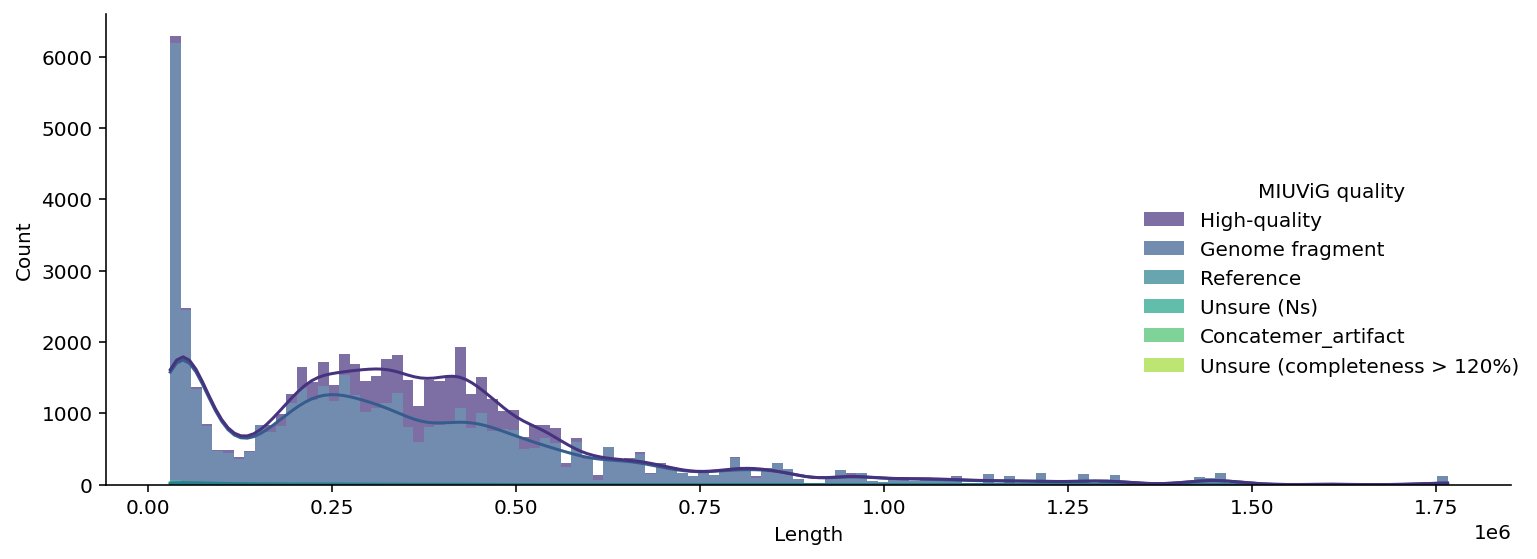

In [6]:
fraglength = 3000

g = seaborn.displot( data=ncldvs[ ncldvs['Length'] > fraglength*min_aln ],
                     x='Length', hue='MIUViG quality',
                     kind='hist', kde=True, multiple='stack',
                     palette='viridis', alpha=0.7,
                     linewidth=0, height=4, aspect=2 )

tight_layout()

Extract contigs from Nucleocytoviricota genomes from IMG/VR v3 and write them to
separate FASTA files under `genome/`

In [103]:
contigs = set( ncldvs['Contig'] )

p = pyprind.ProgBar( dfm.shape[0], 'Extracting and writing Nucleocytoviricota contigs...' )    
with gzip.open( '/global/dna/dm_archive/mep/analyses/AUTO-300263/IMGVR_all_nucleotides.fna.gz', 'rt' ) as fin :
    for n,rec in enumerate( SeqIO.parse( fin, 'fasta' ) ) :
        p.update()
        if rec.id in contigs :
            i,row = next( ncldvs[ ncldvs.Contig == rec.id ].iterrows() )
            if row['coordinates'] == 'whole' :
                start,stop = 0, len(rec)
            else :
                start,stop = [ int(i) for i in row['coordinates'].split('-') ]
            with open( row['filename'], 'a' ) as fout :
                fout.write( rec[start:stop].format('fasta') )

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:41:56


In [5]:
with open( 'genomefiles.txt', 'w' ) as f :
    for name in set( ncldvs.filename ) :
        f.write( name + '\n' )

Run `fastANI` 

**checkpoint 1** :

In [7]:
header = ['query', 'reference', 'ANI', 'bidirectional fragment mappings', 'total query fragments' ]
fastani = pandas.read_csv( 'ncldvs_vs_ncldvs_fastani.txt', sep='\t', names=header )

# drop self-hits
fastani = fastani[ fastani['query'] != fastani['reference'] ]

# de-duplicate (i.e., take the lower triangle of the matrix)
fastani['hash'] = fastani.apply( lambda row : hash( tuple( sorted( ( row['query'], row['reference'] ) ) ) ), axis=1 )
fastani.drop_duplicates( subset='hash', keep='first', inplace=True )
fastani.drop( ['hash'], axis=1, inplace=True )

# append genome lengths
filenames_to_bp = { d['filename'] : d['Length'] for d in ncldvs.loc[:,[ 'filename', 'Length' ]].to_dict( orient='records' ) }
fastani.insert( fastani.shape[1], 'qlen', fastani['query'].map( filenames_to_bp ) )
fastani.insert( fastani.shape[1], 'rlen', fastani['reference'].map( filenames_to_bp ) )

# build mapping dictionaries for UViG taxonomic information
taxonomy = { t : { d['filename'] : d[t] for d in 
                   ncldvs[['filename', t]].to_dict(orient='records') }
             for t in [ 't0','t1','t2','t3','t4','t5','t6','t7' ] }

# merge query taxonomic information with ANI scores
for level,taxmap in taxonomy.items() :
    fastani[level] = fastani['query'].map( taxmap )
fastani.rename( columns={'t0':'qt0','t1':'qt1','t2':'qt2','t3':'qt3','t4':'qt4','t5':'qt5','t6':'qt6','t7':'qt7' },
                     inplace=True )

# merge reference taxonomic information with ANI scores table
for level,taxmap in taxonomy.items() :
    fastani[level] = fastani['reference'].map( taxmap )
fastani.rename( columns={'t0':'rt0','t1':'rt1','t2':'rt2','t3':'rt3','t4':'rt4','t5':'rt5','t6':'rt6','t7':'rt7' },
                     inplace=True )

# tag each ANI hit as between taxa, within taxa or unknownn
taxnames = {
    't0' : 'realm',
    't1' : 'kingdom',
    't2' : 'phylum',
    't3' : 'class',
    't4' : 'order',
    't5' : 'family',
    't6' : 'genus',
    't7' : 'species' }

def taxmapper( query_tax, ref_tax, level='t0' ) :
    if not query_tax : return 'unknown' 
    if not ref_tax : return 'unknown'
    if query_tax == ref_tax : return 'cis-' + taxnames[level]
    else : return 'trans-' + taxnames[level]

for level,taxmap in taxonomy.items() :
    fastani[level] = [ taxmapper( d['q'+level], d['r'+level], level=level ) for d in
                       fastani[['q'+level,'r'+level]].to_dict(orient='records') ]

fastani

,query,reference,ANI,bidirectional fragment mappings,total query fragments,qlen,rlen,qt0,qt1,qt2,...,rt6,rt7,t0,t1,t2,t3,t4,t5,t6,t7
1,genomes/IMGVR_UViG_3300023179_001414.fasta,genomes/IMGVR_UViG_GVMAG-M-3300024502-1_000001...,85.6077,2,3,9065,233813,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,,,cis-realm,cis-kingdom,cis-phylum,cis-class,unknown,unknown,unknown,unknown
2,genomes/IMGVR_UViG_3300023179_001414.fasta,genomes/IMGVR_UViG_GVMAG-M-3300009164-8_000001...,77.1834,1,3,9065,546494,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,,,cis-realm,cis-kingdom,cis-phylum,cis-class,unknown,unknown,unknown,unknown
3,genomes/IMGVR_UViG_3300023179_001414.fasta,genomes/IMGVR_UViG_GVMAG-M-3300012954-33_00000...,77.1834,1,3,9065,298944,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,,,cis-realm,cis-kingdom,cis-phylum,cis-class,unknown,unknown,unknown,unknown
4,genomes/IMGVR_UViG_3300023179_001414.fasta,genomes/IMGVR_UViG_GVMAG-M-3300017967-22_00000...,77.1834,1,3,9065,409197,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,,,cis-realm,cis-kingdom,cis-phylum,cis-class,unknown,unknown,unknown,unknown
5,genomes/IMGVR_UViG_3300023179_001414.fasta,genomes/IMGVR_UViG_3300028569_000011.fasta,74.8976,1,3,9065,127321,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,,,cis-realm,cis-kingdom,cis-phylum,cis-class,unknown,unknown,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27333870,genomes/IMGVR_UViG_3300020238_000039.fasta,genomes/IMGVR_UViG_3300023501_000267.fasta,74.7584,1,2,8872,7438,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,Prasinovirus,,cis-realm,cis-kingdom,cis-phylum,cis-class,cis-order,cis-family,cis-genus,unknown
27333871,genomes/IMGVR_UViG_3300020238_000039.fasta,genomes/IMGVR_UViG_3300022822_000361.fasta,74.7584,1,2,8872,6253,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,Prasinovirus,,cis-realm,cis-kingdom,cis-phylum,cis-class,cis-order,cis-family,cis-genus,unknown
27333882,genomes/IMGVR_UViG_3300020238_000039.fasta,genomes/IMGVR_UViG_3300022842_000305.fasta,74.7584,1,2,8872,5643,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,Prasinovirus,,cis-realm,cis-kingdom,cis-phylum,cis-class,cis-order,cis-family,cis-genus,unknown
27333883,genomes/IMGVR_UViG_3300020238_000039.fasta,genomes/IMGVR_UViG_3300031227_001598.fasta,74.7584,1,2,8872,8708,Varidnaviria,Bamfordvirae,Nucleocytoviricota,...,Prasinovirus,,cis-realm,cis-kingdom,cis-phylum,cis-class,cis-order,cis-family,cis-genus,unknown


In [8]:
fastani.to_csv( 'ncldvs_vs_ncldvs_fastani_taxonomy.tsv', sep='\t' )

In [6]:
fastani = pandas.read_csv( 'ncldvs_vs_ncldvs_fastani_taxonomy.tsv', sep='\t' )

/global/homes/r/ryneches/opt/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**checkpoint 2**

Plot the distribution of ANI scores.

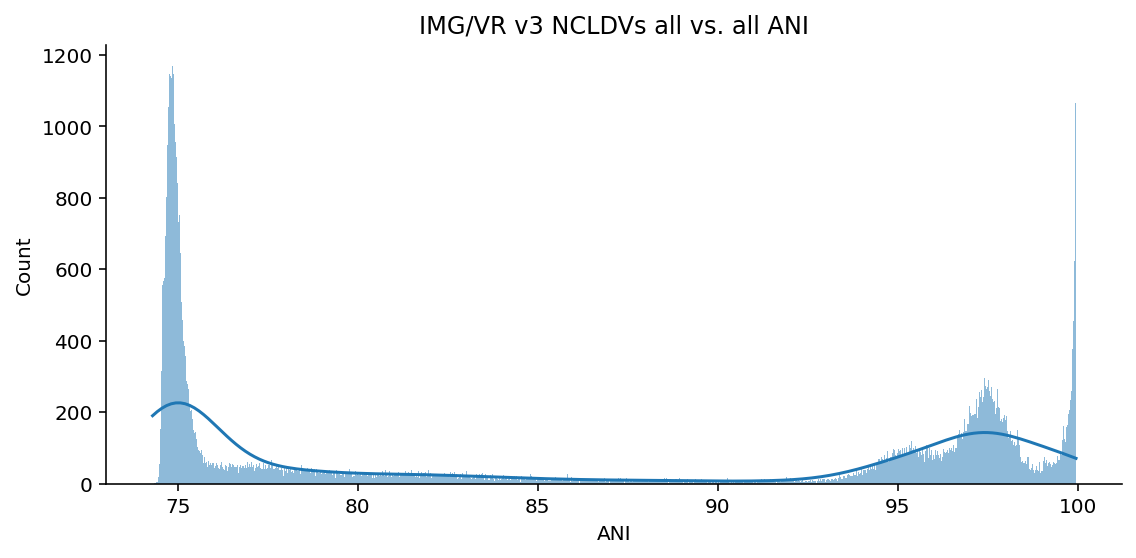

In [9]:
g = seaborn.displot( data=fastani[ ( fastani.ANI < max_ani )
                                 & ( fastani.ANI > 70 )
                                 & ( fastani['bidirectional fragment mappings'] > min_aln ) ],
                         x='ANI', kind='hist', kde=True, bins=1024,
                         fill=True, common_norm=False, palette='viridis', 
                         alpha=.5, linewidth=0, height=4, aspect=2)

title( 'IMG/VR v3 NCLDVs all vs. all ANI' )
tight_layout()
savefig( 'NCLDVs_all_vs_all_ani_alltaxa_hist.png', facecolor='white', dpi=200 )

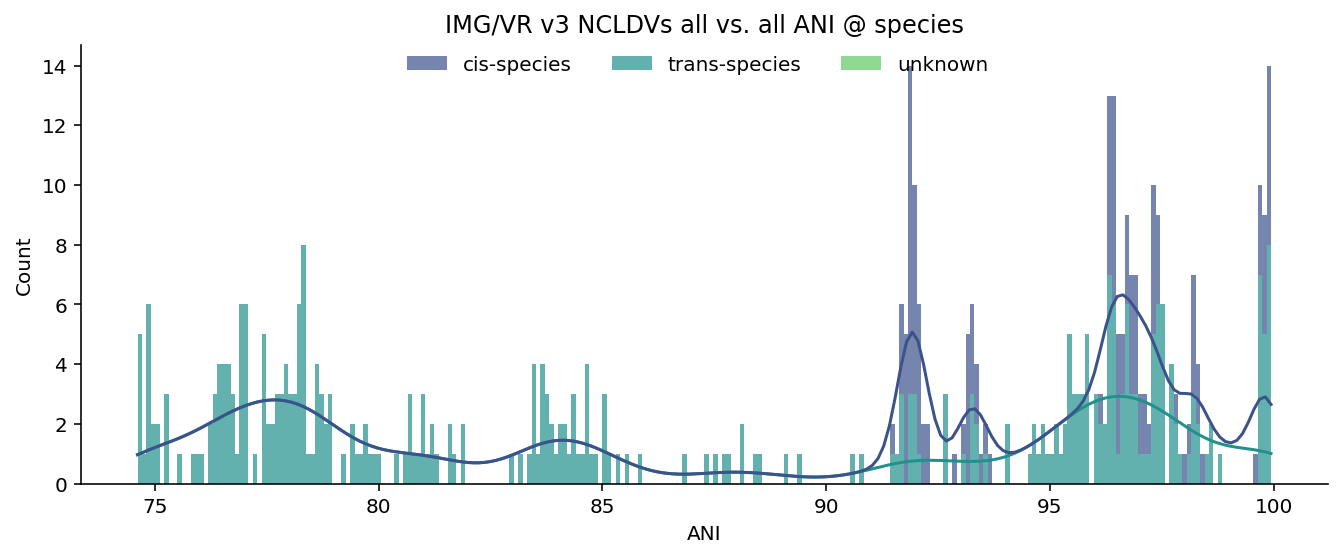

In [37]:
level='t7'

# tag each ANI hit as between taxa, within taxa or unknownn
taxnames = {
    't0' : 'realm',
    't1' : 'kingdom',
    't2' : 'phylum',
    't3' : 'class',
    't4' : 'order',
    't5' : 'family',
    't6' : 'genus',
    't7' : 'species' }

hue_order = sorted( set( fastani[level] ) )

g = seaborn.displot( data=fastani[ ( fastani.ANI < max_ani )
                                 & ( fastani.ANI > 70 )
                                 & ( fastani[level] != 'unknown' )
                                 & ( fastani['bidirectional fragment mappings'] > min_aln ) ],
                         x='ANI', kind='hist', kde=True, kde_kws={'bw_method':0.1}, bins=256,
                         fill=True, multiple='stack', common_norm=False, hue=level, 
                         hue_order=hue_order, palette='viridis',
                         alpha=0.7, linewidth=0, height=4, aspect=2 )

seaborn.move_legend( obj=g, loc='upper center', bbox_to_anchor=(0.52, 0.92), ncol=3, title=None )

#xlim([76,100])

title( 'IMG/VR v3 NCLDVs all vs. all ANI @ ' + taxnames[level] )
tight_layout()
savefig( 'NCLDVs_all_vs_all_ani_hist_' + taxnames[level] + '_stacked.png', facecolor='white', dpi=200 )
#semilogy()

In [34]:
fastani.rt0.value_counts()

Varidnaviria    17554937
Name: rt0, dtype: int64

In [ ]:
seaborn.displot( x=fastani['ANI'], y=(fastani['bidirectional fragment mappings'] * 3000) / fastani['qlen'], kind='kde' )

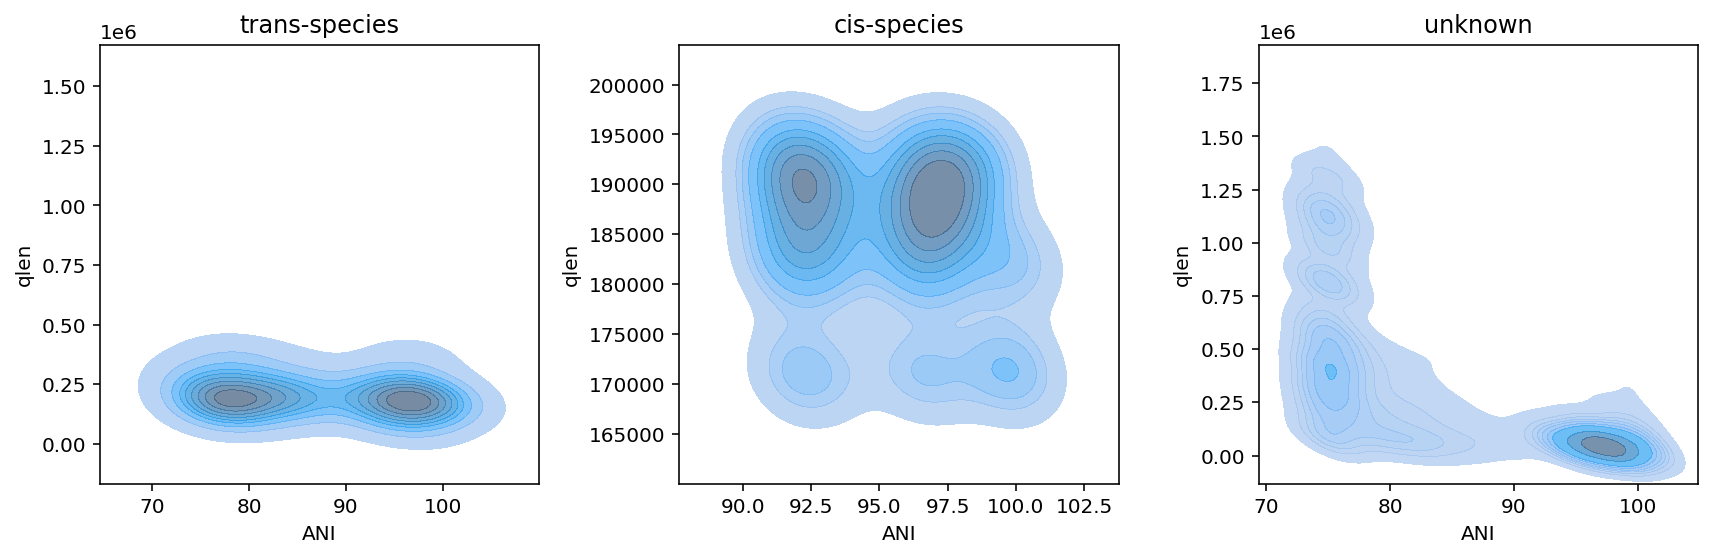

In [24]:
level = 't7'

figure( figsize=(12,4) )
for n,category in enumerate( set( fastani[level] ) ) :
    subplot( 1, 3, n+1 )
    g = seaborn.kdeplot( data=fastani[ ( fastani.ANI < max_ani )
                                     & ( fastani.ANI > 70 )
                                     & ( fastani[level] == category )
                                     & ( fastani['bidirectional fragment mappings'] > min_aln ) ],
                         x='ANI', y='qlen', fill=True, legend=False,
                         palette='viridis', alpha=0.7 )
    title( category )
    
tight_layout()

1+1

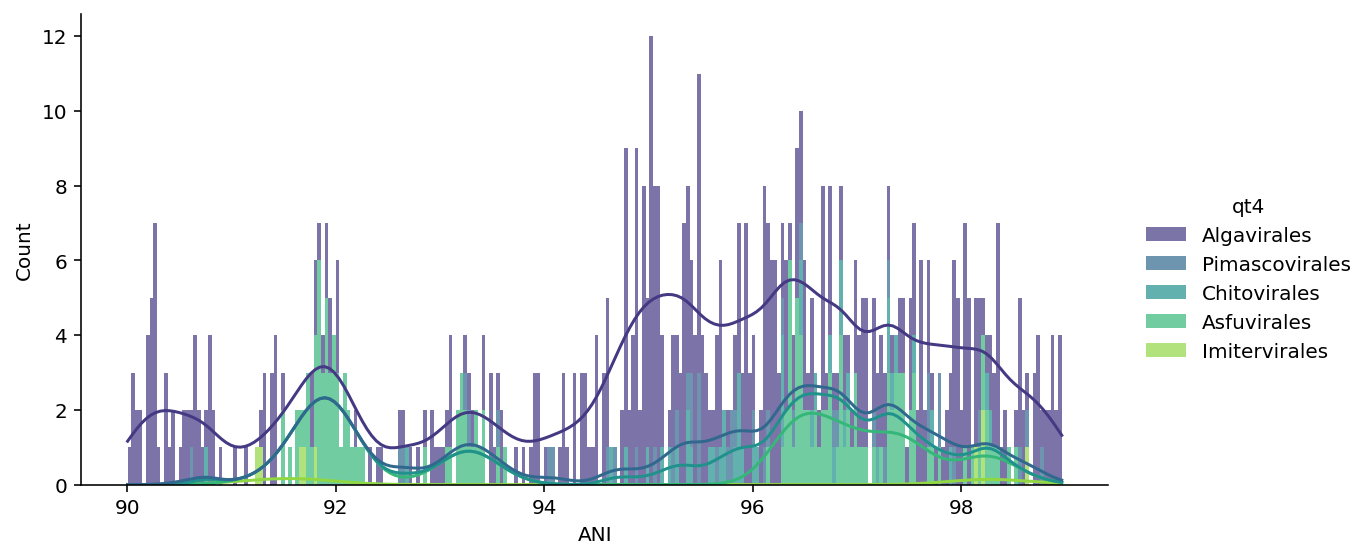

In [47]:
level = 't6'

#hue_order = sorted( set( fastani[ 'q' + taxnames[level] ] ) )

g = seaborn.displot( data=fastani[ ( fastani.ANI < 99 )
                                 & ( fastani.ANI > 90 )
                                 & ( fastani[level] == 'cis-' + taxnames[level] )
                                 & ( fastani['bidirectional fragment mappings'] > min_aln ) ],
                         x='ANI', kind='hist', kde=True, kde_kws={'bw_method':0.1}, bins=256,
                         fill=True, multiple='stack', common_norm=False, hue='qt4', 
                         palette='viridis', #hue_order=hue_order,
                         alpha=0.7, linewidth=0, height=4, aspect=2 )